In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv
import itertools as it
import networkx as nx
import random
import operator

1)

In [3]:
def analizar_grafo(grafo):
    componentes_conexas = [x for x in nx.connected_components(grafo)]
    tupla_componente_gigante = max([(x, len(x)) for x in componentes_conexas], key=lambda x:x[1])

    print("Cantidad de nodos: {0}".format(grafo.number_of_nodes()))
    print("Cantidad de aristas: {0}".format(grafo.number_of_edges()))
    print("Cantidad de componentes conexas: ", len(componentes_conexas))
    print("Cantidad de nodos de la componente conexa gigante: ", tupla_componente_gigante[1])
    
    G = grafo.subgraph(tupla_componente_gigante[0])
    #print(type(G))
    
    print("Segunda Componente :")
    segunda = grafo.copy()
    segunda.remove_nodes_from(G)
    if segunda.number_of_nodes() > 0 :
        componentes_conexas = [x for x in nx.connected_components(segunda)]
        tupla_componente_gigante = max([(x, len(x)) for x in componentes_conexas], key=lambda x:x[1])

        print("Cantidad de nodos: {0}".format(segunda.number_of_nodes()))
        print("Cantidad de aristas: {0}".format(segunda.number_of_edges()))
        print("Cantidad de componentes conexas: ", len(componentes_conexas))
        print("Cantidad de nodos de la componente conexa gigante: ", tupla_componente_gigante[1])
    
    return G

In [4]:
G = nx.Graph()

with open('./data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        autores = [autor.strip() for autor in row[3].split('&')]
        coautorias = it.combinations(autores, 2)
        G.add_edges_from(coautorias)


In [5]:
analizar_grafo(G)

Cantidad de nodos: 3698
Cantidad de aristas: 7880
Cantidad de componentes conexas:  236
Cantidad de nodos de la componente conexa gigante:  3018
Segunda Componente :
Cantidad de nodos: 680
Cantidad de aristas: 611
Cantidad de componentes conexas:  235
Cantidad de nodos de la componente conexa gigante:  18


In [95]:
nx.draw(G)

TypeError: 'module' object is not callable

2)

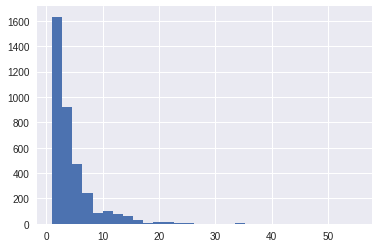

In [6]:
grados = list(nx.degree(G).values())
count, bins, patches = plt.hist(grados, bins=30)
plt.show()

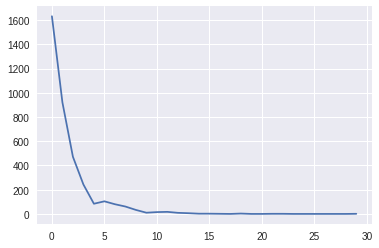

In [7]:
plt.plot(count)

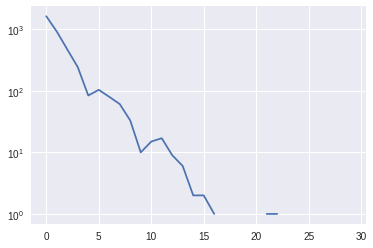

In [8]:
plt.semilogy(count)

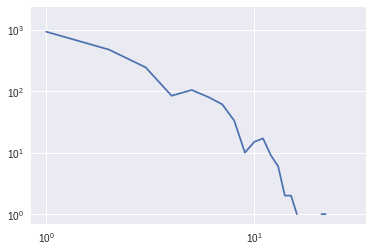

In [9]:
plt.loglog(count)

3)

In [10]:
componentes_conexas = [x for x in nx.connected_components(G)]

tupla_componente_gigante = max([(x, len(x)) for x in componentes_conexas], key=lambda x:x[1])

print("cantidad de componentes conexas: ", len(componentes_conexas))
print("componente conexa gigante: ", tupla_componente_gigante[1])

cantidad de componentes conexas:  236
componente conexa gigante:  3018


4)

In [12]:
def invert_map(map):
    inv_map = {}
    for k, v in map.items():
        inv_map.setdefault(v, [])
        inv_map[v].append(k)
    return inv_map

def authors_by_distance(componente_gigante):
    nodo_raiz_idx = random.randint(0, len(componente_gigante) - 1)
    nodo_raiz = componente_gigante.nodes()[nodo_raiz_idx]

    paths = invert_map(all_distances[nodo_raiz])
    diferencial = {}
    
    previous_quantity = 0
    for distance in sorted(paths.keys()):
        diferencial[distance] = len(paths[distance]) 
        
    return diferencial

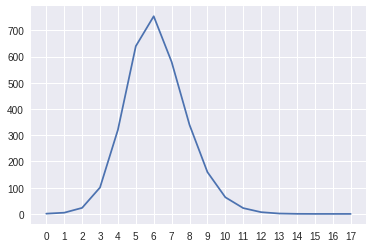

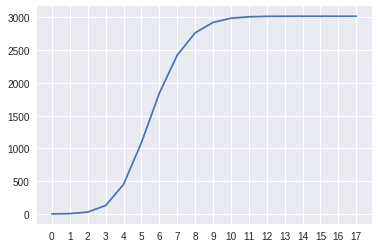

In [13]:
componente_gigante = G.subgraph(tupla_componente_gigante[0])

all_distances = nx.all_pairs_shortest_path_length(componente_gigante)

iterations = 2000
longest_path = max([max(node_distances.values()) for node_distances in all_distances.values()]) + 1
results = np.zeros((iterations, longest_path), dtype=int)

for iteration in range(iterations):
    diferencial = authors_by_distance(componente_gigante)
    
    for distance, quantity in diferencial.items():
        results[iteration, distance] = quantity

diferencial_means = results.mean(axis=0)
incremental_means = []

previous_quantity = 0
for quantity in diferencial_means:
    incremental_means.append(quantity + previous_quantity)
    previous_quantity = quantity + previous_quantity

def plot(y):
    sns.plt.figure()
    sns.plt.xticks(range(longest_path+1))
    sns.plt.plot(range(longest_path),y)


plot(diferencial_means)
plot(incremental_means)

5)

In [14]:
clustering = nx.average_clustering(componente_gigante)
avg_shortest_path_length = nx.average_shortest_path_length(componente_gigante)

degrees_seq = list(dict(componente_gigante.degree()).values())
# Hago un grafo aleatorio con la distribución de grados
GR = nx.configuration_model(degrees_seq, create_using=nx.Graph())


#Me quedo con la componente conexa más grande del grafo aleatoreo
componentes_conexas = [x for x in nx.connected_components(GR)]
tupla_componente_gigante = max([(x, len(x)) for x in componentes_conexas], key=lambda x:x[1])

random_G = GR.subgraph(tupla_componente_gigante[0])
print(nx.Graph(random_G))

clustering_random = nx.average_clustering(random_G)
avg_shortest_path_length_random = nx.average_shortest_path_length(random_G)

print('Grafo componente gigante:')
print('\tClustering: {0}'.format(clustering))
print('\tCamino minimo medio: {0}'.format(avg_shortest_path_length))

print(u'Grafo aleatorio con la misma distribución:')
print('\tClustering: {0}'.format(clustering_random))
print('\tCamino minimo medio: {0}'.format(avg_shortest_path_length_random))

configuration_model 3018 nodes 7251 edges
Grafo componente gigante:
	Clustering: 0.4840014369969904
	Camino minimo medio: 6.131037221593651
Grafo aleatorio con la misma distribución:
	Clustering: 0.004343054937329409
	Camino minimo medio: 4.730256097165521


6)

In [20]:
def analizar_centralidad(grafo, repeticiones, degree):
    completo = grafo.copy()
    
    for i in range(repeticiones):
        print("iteracion: ", i)
        componente_gigante = analizar_grafo(completo)
        
        if degree :
            degree_centralty = nx.degree_centrality(componente_gigante)
        else :
            betweenness_centralty = nx.betweenness_centrality(componente_gigante)
        
        if degree :
            important_node = max(degree_centralty.items(), key=operator.itemgetter(1))[0]
        else :
            important_node = max(betweenness_centralty.items(), key=operator.itemgetter(1))[0]
        
        completo.remove_node(important_node)
        print()

In [19]:
analizar_centralidad(G,500,True)

iteracion:  0
Cantidad de nodos: 3698
Cantidad de aristas: 7880
Cantidad de componentes conexas:  236
Cantidad de nodos de la componente conexa gigante:  3018
Segunda Componente :
Cantidad de nodos: 680
Cantidad de aristas: 611
Cantidad de componentes conexas:  235
Cantidad de nodos de la componente conexa gigante:  18

iteracion:  1
Cantidad de nodos: 3697
Cantidad de aristas: 7826
Cantidad de componentes conexas:  240
Cantidad de nodos de la componente conexa gigante:  3013
Segunda Componente :
Cantidad de nodos: 684
Cantidad de aristas: 611
Cantidad de componentes conexas:  239
Cantidad de nodos de la componente conexa gigante:  18

iteracion:  2
Cantidad de nodos: 3696
Cantidad de aristas: 7785
Cantidad de componentes conexas:  240
Cantidad de nodos de la componente conexa gigante:  3012
Segunda Componente :
Cantidad de nodos: 684
Cantidad de aristas: 611
Cantidad de componentes conexas:  239
Cantidad de nodos de la componente conexa gigante:  18

iteracion:  3
Cantidad de nodos: 3

Cantidad de aristas: 7138
Cantidad de componentes conexas:  265
Cantidad de nodos de la componente conexa gigante:  2954
Segunda Componente :
Cantidad de nodos: 717
Cantidad de aristas: 621
Cantidad de componentes conexas:  264
Cantidad de nodos de la componente conexa gigante:  18

iteracion:  28
Cantidad de nodos: 3670
Cantidad de aristas: 7116
Cantidad de componentes conexas:  267
Cantidad de nodos de la componente conexa gigante:  2950
Segunda Componente :
Cantidad de nodos: 720
Cantidad de aristas: 622
Cantidad de componentes conexas:  266
Cantidad de nodos de la componente conexa gigante:  18

iteracion:  29
Cantidad de nodos: 3669
Cantidad de aristas: 7094
Cantidad de componentes conexas:  268
Cantidad de nodos de la componente conexa gigante:  2930
Segunda Componente :
Cantidad de nodos: 739
Cantidad de aristas: 741
Cantidad de componentes conexas:  267
Cantidad de nodos de la componente conexa gigante:  19

iteracion:  30
Cantidad de nodos: 3668
Cantidad de aristas: 7073
Canti

Cantidad de componentes conexas:  305
Cantidad de nodos de la componente conexa gigante:  2824
Segunda Componente :
Cantidad de nodos: 819
Cantidad de aristas: 797
Cantidad de componentes conexas:  304
Cantidad de nodos de la componente conexa gigante:  19

iteracion:  56
Cantidad de nodos: 3642
Cantidad de aristas: 6596
Cantidad de componentes conexas:  308
Cantidad de nodos de la componente conexa gigante:  2816
Segunda Componente :
Cantidad de nodos: 826
Cantidad de aristas: 801
Cantidad de componentes conexas:  307
Cantidad de nodos de la componente conexa gigante:  19

iteracion:  57
Cantidad de nodos: 3641
Cantidad de aristas: 6579
Cantidad de componentes conexas:  310
Cantidad de nodos de la componente conexa gigante:  2808
Segunda Componente :
Cantidad de nodos: 833
Cantidad de aristas: 809
Cantidad de componentes conexas:  309
Cantidad de nodos de la componente conexa gigante:  19

iteracion:  58
Cantidad de nodos: 3640
Cantidad de aristas: 6563
Cantidad de componentes conexas

Cantidad de nodos de la componente conexa gigante:  19

iteracion:  110
Cantidad de nodos: 3588
Cantidad de aristas: 5826
Cantidad de componentes conexas:  358
Cantidad de nodos de la componente conexa gigante:  2636
Segunda Componente :
Cantidad de nodos: 952
Cantidad de aristas: 904
Cantidad de componentes conexas:  357
Cantidad de nodos de la componente conexa gigante:  19

iteracion:  111
Cantidad de nodos: 3587
Cantidad de aristas: 5814
Cantidad de componentes conexas:  358
Cantidad de nodos de la componente conexa gigante:  2635
Segunda Componente :
Cantidad de nodos: 952
Cantidad de aristas: 904
Cantidad de componentes conexas:  357
Cantidad de nodos de la componente conexa gigante:  19

iteracion:  112
Cantidad de nodos: 3586
Cantidad de aristas: 5802
Cantidad de componentes conexas:  358
Cantidad de nodos de la componente conexa gigante:  2634
Segunda Componente :
Cantidad de nodos: 952
Cantidad de aristas: 904
Cantidad de componentes conexas:  357
Cantidad de nodos de la comp

Cantidad de nodos de la componente conexa gigante:  29

iteracion:  144
Cantidad de nodos: 3554
Cantidad de aristas: 5435
Cantidad de componentes conexas:  389
Cantidad de nodos de la componente conexa gigante:  2485
Segunda Componente :
Cantidad de nodos: 1069
Cantidad de aristas: 1040
Cantidad de componentes conexas:  388
Cantidad de nodos de la componente conexa gigante:  29

iteracion:  145
Cantidad de nodos: 3553
Cantidad de aristas: 5424
Cantidad de componentes conexas:  390
Cantidad de nodos de la componente conexa gigante:  2479
Segunda Componente :
Cantidad de nodos: 1074
Cantidad de aristas: 1045
Cantidad de componentes conexas:  389
Cantidad de nodos de la componente conexa gigante:  29

iteracion:  146
Cantidad de nodos: 3552
Cantidad de aristas: 5413
Cantidad de componentes conexas:  391
Cantidad de nodos de la componente conexa gigante:  2472
Segunda Componente :
Cantidad de nodos: 1080
Cantidad de aristas: 1060
Cantidad de componentes conexas:  390
Cantidad de nodos de l


iteracion:  205
Cantidad de nodos: 3493
Cantidad de aristas: 4847
Cantidad de componentes conexas:  451
Cantidad de nodos de la componente conexa gigante:  2234
Segunda Componente :
Cantidad de nodos: 1259
Cantidad de aristas: 1250
Cantidad de componentes conexas:  450
Cantidad de nodos de la componente conexa gigante:  29

iteracion:  206
Cantidad de nodos: 3492
Cantidad de aristas: 4838
Cantidad de componentes conexas:  452
Cantidad de nodos de la componente conexa gigante:  2231
Segunda Componente :
Cantidad de nodos: 1261
Cantidad de aristas: 1251
Cantidad de componentes conexas:  451
Cantidad de nodos de la componente conexa gigante:  29

iteracion:  207
Cantidad de nodos: 3491
Cantidad de aristas: 4829
Cantidad de componentes conexas:  453
Cantidad de nodos de la componente conexa gigante:  2228
Segunda Componente :
Cantidad de nodos: 1263
Cantidad de aristas: 1252
Cantidad de componentes conexas:  452
Cantidad de nodos de la componente conexa gigante:  29

iteracion:  208
Canti

Cantidad de nodos de la componente conexa gigante:  29

iteracion:  240
Cantidad de nodos: 3458
Cantidad de aristas: 4553
Cantidad de componentes conexas:  499
Cantidad de nodos de la componente conexa gigante:  2061
Segunda Componente :
Cantidad de nodos: 1397
Cantidad de aristas: 1387
Cantidad de componentes conexas:  498
Cantidad de nodos de la componente conexa gigante:  29

iteracion:  241
Cantidad de nodos: 3457
Cantidad de aristas: 4545
Cantidad de componentes conexas:  499
Cantidad de nodos de la componente conexa gigante:  2060
Segunda Componente :
Cantidad de nodos: 1397
Cantidad de aristas: 1387
Cantidad de componentes conexas:  498
Cantidad de nodos de la componente conexa gigante:  29

iteracion:  242
Cantidad de nodos: 3456
Cantidad de aristas: 4537
Cantidad de componentes conexas:  501
Cantidad de nodos de la componente conexa gigante:  2053
Segunda Componente :
Cantidad de nodos: 1403
Cantidad de aristas: 1392
Cantidad de componentes conexas:  500
Cantidad de nodos de l

Cantidad de componentes conexas:  556
Cantidad de nodos de la componente conexa gigante:  1795
Segunda Componente :
Cantidad de nodos: 1627
Cantidad de aristas: 1652
Cantidad de componentes conexas:  555
Cantidad de nodos de la componente conexa gigante:  47

iteracion:  277
Cantidad de nodos: 3421
Cantidad de aristas: 4267
Cantidad de componentes conexas:  556
Cantidad de nodos de la componente conexa gigante:  1794
Segunda Componente :
Cantidad de nodos: 1627
Cantidad de aristas: 1652
Cantidad de componentes conexas:  555
Cantidad de nodos de la componente conexa gigante:  47

iteracion:  278
Cantidad de nodos: 3420
Cantidad de aristas: 4260
Cantidad de componentes conexas:  556
Cantidad de nodos de la componente conexa gigante:  1793
Segunda Componente :
Cantidad de nodos: 1627
Cantidad de aristas: 1652
Cantidad de componentes conexas:  555
Cantidad de nodos de la componente conexa gigante:  47

iteracion:  279
Cantidad de nodos: 3419
Cantidad de aristas: 4253
Cantidad de componente

iteracion:  334
Cantidad de nodos: 3364
Cantidad de aristas: 3885
Cantidad de componentes conexas:  643
Cantidad de nodos de la componente conexa gigante:  1367
Segunda Componente :
Cantidad de nodos: 1997
Cantidad de aristas: 2035
Cantidad de componentes conexas:  642
Cantidad de nodos de la componente conexa gigante:  52

iteracion:  335
Cantidad de nodos: 3363
Cantidad de aristas: 3879
Cantidad de componentes conexas:  645
Cantidad de nodos de la componente conexa gigante:  1337
Segunda Componente :
Cantidad de nodos: 2026
Cantidad de aristas: 2068
Cantidad de componentes conexas:  644
Cantidad de nodos de la componente conexa gigante:  52

iteracion:  336
Cantidad de nodos: 3362
Cantidad de aristas: 3873
Cantidad de componentes conexas:  646
Cantidad de nodos de la componente conexa gigante:  1335
Segunda Componente :
Cantidad de nodos: 2027
Cantidad de aristas: 2068
Cantidad de componentes conexas:  645
Cantidad de nodos de la componente conexa gigante:  52

iteracion:  337
Cantid


iteracion:  380
Cantidad de nodos: 3318
Cantidad de aristas: 3617
Cantidad de componentes conexas:  725
Cantidad de nodos de la componente conexa gigante:  643
Segunda Componente :
Cantidad de nodos: 2675
Cantidad de aristas: 2793
Cantidad de componentes conexas:  724
Cantidad de nodos de la componente conexa gigante:  76

iteracion:  381
Cantidad de nodos: 3317
Cantidad de aristas: 3612
Cantidad de componentes conexas:  726
Cantidad de nodos de la componente conexa gigante:  624
Segunda Componente :
Cantidad de nodos: 2693
Cantidad de aristas: 2812
Cantidad de componentes conexas:  725
Cantidad de nodos de la componente conexa gigante:  76

iteracion:  382
Cantidad de nodos: 3316
Cantidad de aristas: 3607
Cantidad de componentes conexas:  727
Cantidad de nodos de la componente conexa gigante:  515
Segunda Componente :
Cantidad de nodos: 2801
Cantidad de aristas: 2947
Cantidad de componentes conexas:  726
Cantidad de nodos de la componente conexa gigante:  108

iteracion:  383
Cantida

Cantidad de nodos de la componente conexa gigante:  65

iteracion:  408
Cantidad de nodos: 3290
Cantidad de aristas: 3479
Cantidad de componentes conexas:  776
Cantidad de nodos de la componente conexa gigante:  65
Segunda Componente :
Cantidad de nodos: 3225
Cantidad de aristas: 3393
Cantidad de componentes conexas:  775
Cantidad de nodos de la componente conexa gigante:  65

iteracion:  409
Cantidad de nodos: 3289
Cantidad de aristas: 3474
Cantidad de componentes conexas:  779
Cantidad de nodos de la componente conexa gigante:  65
Segunda Componente :
Cantidad de nodos: 3224
Cantidad de aristas: 3395
Cantidad de componentes conexas:  778
Cantidad de nodos de la componente conexa gigante:  65

iteracion:  410
Cantidad de nodos: 3288
Cantidad de aristas: 3469
Cantidad de componentes conexas:  782
Cantidad de nodos de la componente conexa gigante:  65
Segunda Componente :
Cantidad de nodos: 3223
Cantidad de aristas: 3392
Cantidad de componentes conexas:  781
Cantidad de nodos de la comp


iteracion:  463
Cantidad de nodos: 3235
Cantidad de aristas: 3213
Cantidad de componentes conexas:  893
Cantidad de nodos de la componente conexa gigante:  23
Segunda Componente :
Cantidad de nodos: 3212
Cantidad de aristas: 3189
Cantidad de componentes conexas:  892
Cantidad de nodos de la componente conexa gigante:  22

iteracion:  464
Cantidad de nodos: 3234
Cantidad de aristas: 3210
Cantidad de componentes conexas:  895
Cantidad de nodos de la componente conexa gigante:  22
Segunda Componente :
Cantidad de nodos: 3212
Cantidad de aristas: 3182
Cantidad de componentes conexas:  894
Cantidad de nodos de la componente conexa gigante:  22

iteracion:  465
Cantidad de nodos: 3233
Cantidad de aristas: 3205
Cantidad de componentes conexas:  897
Cantidad de nodos de la componente conexa gigante:  22
Segunda Componente :
Cantidad de nodos: 3211
Cantidad de aristas: 3180
Cantidad de componentes conexas:  896
Cantidad de nodos de la componente conexa gigante:  22

iteracion:  466
Cantidad de

Hablar del chamuyo de que pensabamos que en pocos pasos se iban a separar las comunidades y nos dió que alrededor del 10% DE LOS AUTORES MAS IMPORTANTES HAY QUE BORRAR PARA ROMPERLO

hacer algún gráfico loco